In [19]:
import numpy as np
import pandas as pd

#import shap

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import (accuracy_score,
                             recall_score,
                             precision_score,
                             f1_score,
                             confusion_matrix,
                             classification_report)


In [20]:
raw_data = load_iris(as_frame=True)
raw_data['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [21]:
X = pd.DataFrame(data=raw_data['data'])
y = pd.DataFrame(data=raw_data['target'])

data = pd.concat(objs=(X, y), axis=1)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [23]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5
target,150.0,1.000000,0.819232,0.0,0.0,1.00,2.0,2.0


In [24]:
data.rename(
    columns = {'sepal length (cm)' : 'sepal_length',
     'sepal width (cm)': 'sepal_width',
     'petal length (cm)': 'petal_length',
     'petal width (cm)': 'petal_width',},
    inplace=True
)

data['target_names'] = data['target'].map(lambda val: raw_data.target_names[val])
data

,sepal_length,sepal_width,petal_length,petal_width,target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


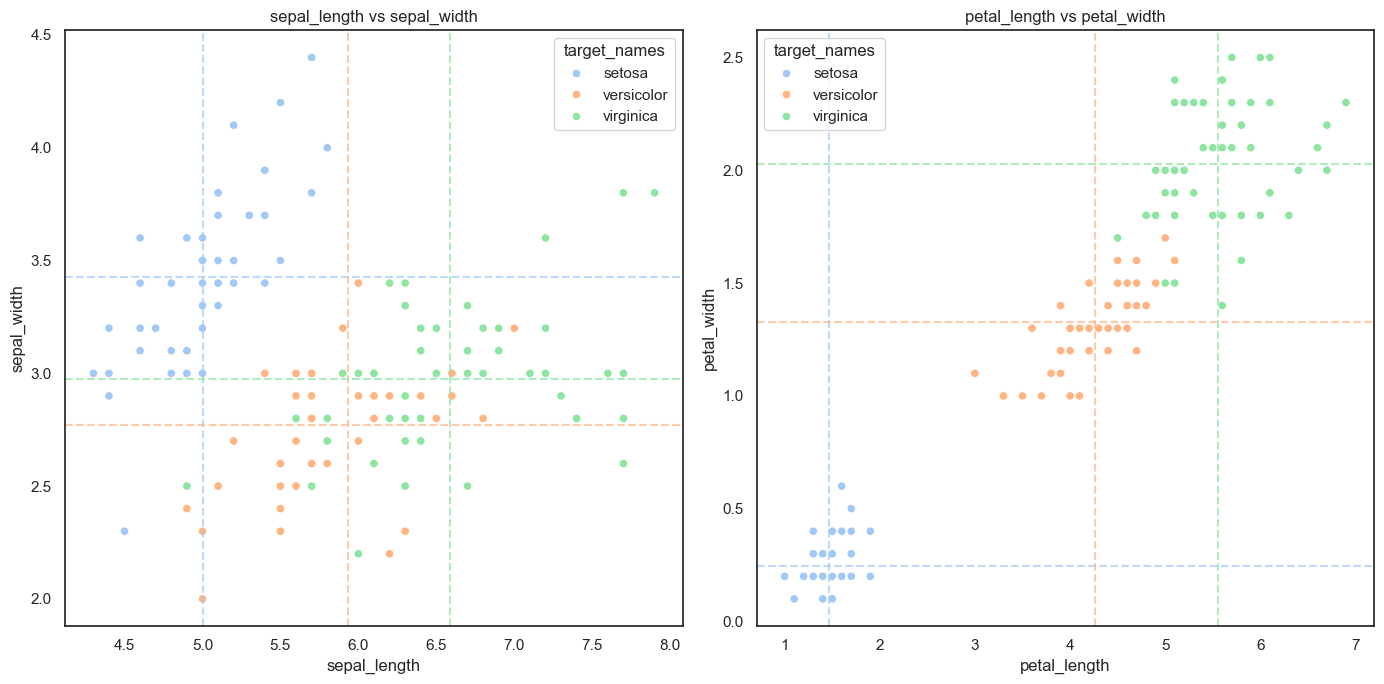

In [25]:

def iris_scatterplot(ds, xs, ys):
    if len(xs) != len(ys):
        return None
    
    fig, ax = plt.subplots(nrows=1, ncols=len(xs), figsize=(14,7))
    ax = ax.flatten()
    
    for idx, (x,y) in enumerate(zip(xs,ys)):
        sns.scatterplot(data=ds,
                        x = x,
                        y = y,
                        hue = 'target_names',
                        palette='pastel',
                        ax=ax[idx])

        for i, species in enumerate(data['target_names'].unique()):
            condition = data['target_names'] == species
            subset = data.loc[condition,:]
            
            mean_sl = subset[x].mean() #x
            mean_sw = subset[y].mean() #y
            
            ax[idx].axvline(mean_sl, linestyle='--', color=sns.color_palette('pastel')[i], alpha = 0.7)
            ax[idx].axhline(mean_sw, linestyle='--', color=sns.color_palette('pastel')[i], alpha = 0.7)
            
        ax[idx].set_title(f'{x} vs {y}')
    plt.tight_layout()
    
iris_scatterplot(ds=data, xs = ('sepal_length', 'petal_length'),
                          ys = ('sepal_width', 'petal_width'))

<Figure size 1000x800 with 0 Axes>

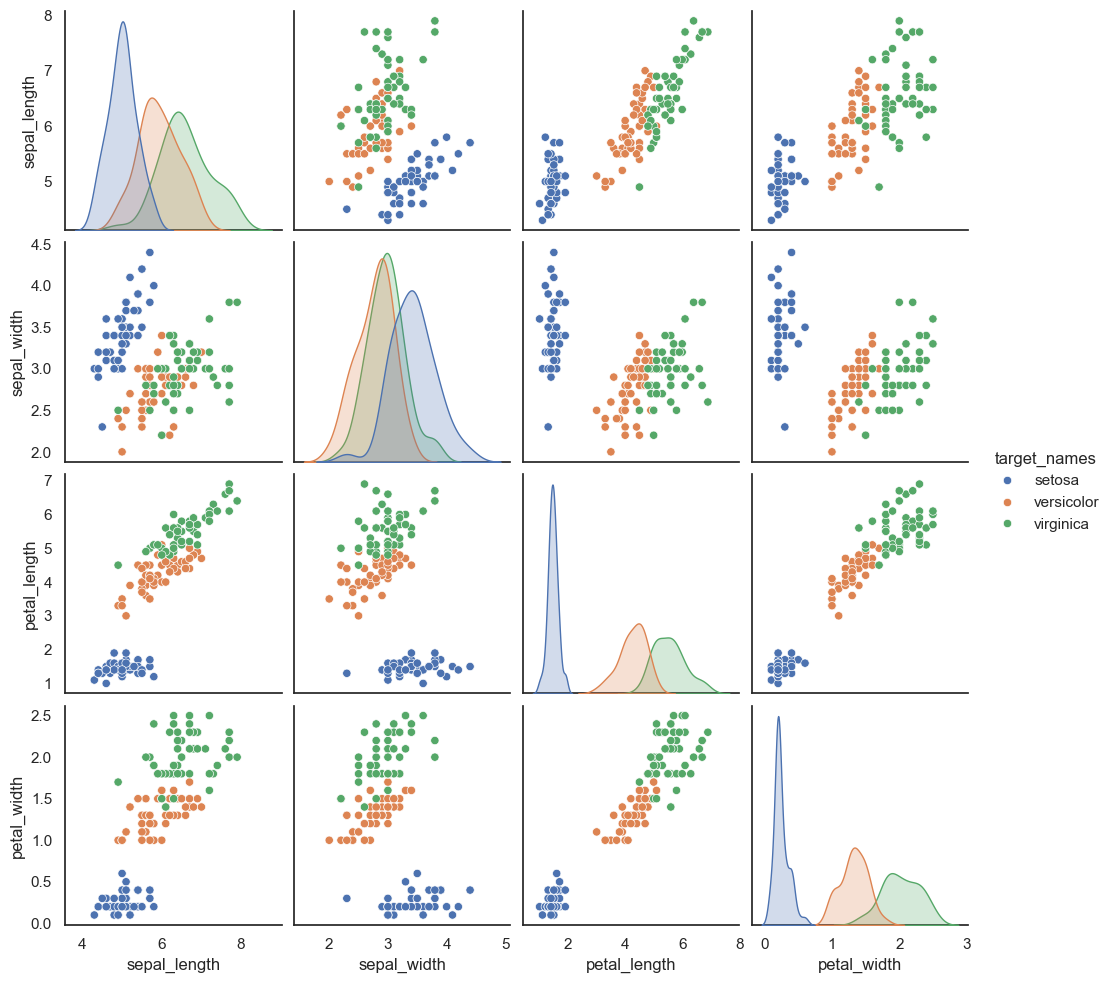

In [26]:
plt.figure(figsize=(10,8))
sns.pairplot(data=data.drop('target', axis=1),
             hue='target_names')

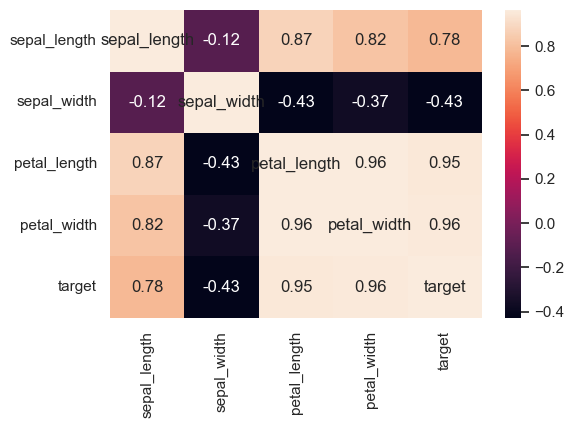

In [27]:
fig, ax = plt.subplots(figsize=(6,4))
numerical_subset = data.select_dtypes(include=[int, float])
                        
numerical_corr = numerical_subset.corr()
min_corr = numerical_corr.min().min()
max_corr = numerical_corr[numerical_corr < 1].max().max()
annot_matrix = numerical_corr.round(2).astype(str)
np.fill_diagonal(annot_matrix.values, [f'{feature}' for feature in numerical_corr.columns])

sns.heatmap(data=numerical_corr,
            annot=annot_matrix,
            fmt='',
            vmax=max_corr,
            vmin=min_corr,
            ax=ax)
plt.show()

In [28]:
X = data["sepal_length sepal_width petal_length petal_width".split(' ')]
y = data.target

variance explained by PCA1: 0.99
variance explained by PCA2: 0.01


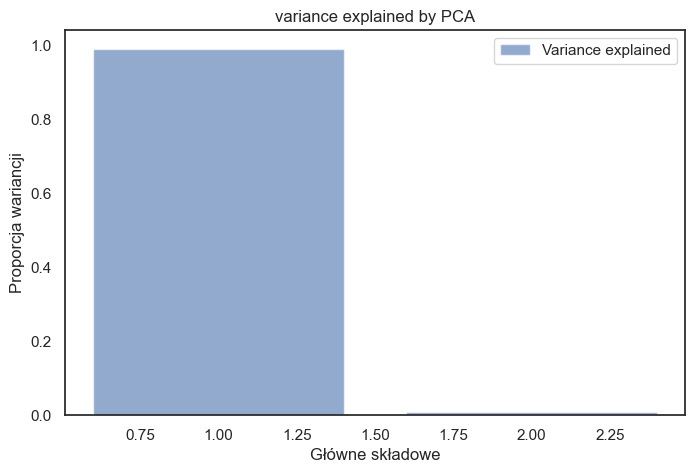

In [29]:
X_petal = X[['petal_length', 'petal_width']]

pca = PCA(n_components=2)

X_petal_pca = pca.fit_transform(X_petal)

explained_variance = pca.explained_variance_ratio_
print(f'variance explained by PCA1: {explained_variance[0]:.2f}')
print(f'variance explained by PCA2: {explained_variance[1]:.2f}')

plt.figure(figsize=(8,5))
plt.bar(range(1, 3), explained_variance, alpha=0.6, color='b', label='Variance explained')
plt.ylabel('Proporcja wariancji')
plt.xlabel('Główne składowe')
plt.title('variance explained by PCA')
plt.legend()
plt.show()

In [30]:
X['petal_pca'] = X_petal_pca[:, 0]

X = X.drop(columns=['petal_length', 'petal_width'])

<Axes: >

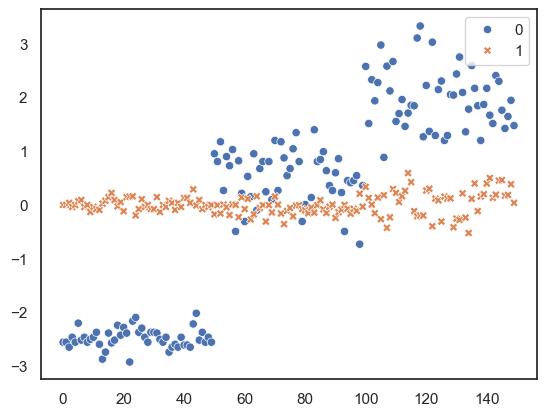

In [31]:
sns.scatterplot(X_petal_pca)

In [32]:
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X_st = pd.DataFrame(standard_scaler.fit_transform(X),
                    columns = X.columns)

X_mm = pd.DataFrame(minmax_scaler.fit_transform(X),
                    columns = X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_st, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
def manage_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    return [
        precision_score(y_train, y_train_pred, average='weighted'),
        precision_score(y_test, y_test_pred, average='weighted'),
        recall_score(y_train, y_train_pred, average='weighted'),
        recall_score(y_test, y_test_pred, average='weighted'),
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred),
        f1_score(y_train, y_train_pred, average='weighted'),
        f1_score(y_test, y_test_pred, average='weighted')
    ]

In [34]:
models = dict(
    log_reg=LogisticRegression(max_iter=1000, random_state=42),
    tree=DecisionTreeClassifier(random_state=42),
    random_forest=RandomForestClassifier(random_state=42),
    svc=SVC(probability=True, random_state=42),
    knn=KNeighborsClassifier()
)

param_grid = {
    'log_reg': {
        'C': [.0001, .01, .1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', None], 
        'solver': ['lbfgs', 'liblinear', 'saga']
    },
    'tree': {
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 20],
        'criterion': ['gini', 'entropy']
    },
    'random_forest': {
        'n_estimators': [50, 100, 200, 350],
        'max_depth': [None, 5, 10, 20, 30],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 20],
        'max_features': ['sqrt', 'log2'] 
    },
    'svc': {
        'C': [.01, .1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', .01, .1, 1],  
        'degree': [2, 3, 4]  
    },
    'knn': {
        'n_neighbors': [5, 7, 10]
    }
}

index = ['precision_train', 'precision_test', 'recall_train', 'recall_test',
         'accuracy_train', 'accuracy_test', 'F1_train', 'F1_test']
summary = pd.DataFrame(index=index)


rsf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=132)

for model_name, model_e in models.items():
    print(f'Tuning model {model_name}...')

    rg_search = RandomizedSearchCV(
        model_e,
        param_distributions=param_grid[model_name],
        cv=rsf,
        scoring='accuracy',
        n_iter=20,
        n_jobs=-1,
        random_state=42
    )
    
    rg_search.fit(X_train, y_train)
    best_params = rg_search.best_params_

    print(f'Best params for {model_name}: {best_params}')
    model_e.set_params(**best_params)
    model_e.fit(X_train, y_train)

    try:
        if isinstance(model_e, RandomForestClassifier):
            feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': model_e.feature_importances_})
            feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    except Exception as e:
        pass

    summary[model_name] = manage_model(model_e, X_train, X_test, y_train, y_test)

print(summary)
print(feature_importance)

Tuning model log_reg...
Best params for log_reg: {'solver': 'lbfgs', 'penalty': None, 'C': 10}
Tuning model tree...
Best params for tree: {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'entropy'}
Tuning model random_forest...
Best params for random_forest: {'n_estimators': 350, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 10}
Tuning model svc...
Best params for svc: {'kernel': 'rbf', 'gamma': 0.01, 'degree': 4, 'C': 100}
Tuning model knn...
Best params for knn: {'n_neighbors': 5}
                  log_reg      tree  random_forest       svc       knn
precision_train  0.983333  0.975193       0.983333  0.983333  0.950000
precision_test   0.969697  0.969697       0.933333  0.969697  0.902357
recall_train     0.983333  0.975000       0.983333  0.983333  0.950000
recall_test      0.966667  0.966667       0.933333  0.966667  0.900000
accuracy_train   0.983333  0.975000       0.983333  0.983333  0.950000
accuracy_test    0.9

In [35]:
summary

,log_reg,tree,random_forest,svc,knn
precision_train,0.983333,0.975193,0.983333,0.983333,0.950000
precision_test,0.969697,0.969697,0.933333,0.969697,0.902357
recall_train,0.983333,0.975000,0.983333,0.983333,0.950000
recall_test,0.966667,0.966667,0.933333,0.966667,0.900000
accuracy_train,0.983333,0.975000,0.983333,0.983333,0.950000
accuracy_test,0.966667,0.966667,0.933333,0.966667,0.900000
F1_train,0.983333,0.974996,0.983333,0.983333,0.950000
F1_test,0.966583,0.966583,0.933333,0.966583,0.899749


In [36]:
vertical_con = summary.index.str.contains('test')
summary.loc[vertical_con,:]

,log_reg,tree,random_forest,svc,knn
precision_test,0.969697,0.969697,0.933333,0.969697,0.902357
recall_test,0.966667,0.966667,0.933333,0.966667,0.900000
accuracy_test,0.966667,0.966667,0.933333,0.966667,0.900000
F1_test,0.966583,0.966583,0.933333,0.966583,0.899749
